# 分布直方图

In [13]:
import pandas as pd
import os
import numpy as np

folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
# file_path = os.path.join(folder_path, 'S2_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去
file_path = os.path.join(folder_path, 'S1_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去
df = pd.read_excel(file_path)
y_log =  df.iloc[:, -1].values 
# y_log = np.log(y_exp)

In [14]:
x1 = y_log

In [15]:
color_sets = ['blue', 'green']
color_1 = (147/255, 85/255, 150/255)
color_2 = (116/255, 160/255, 161/255)

# label_x = ' log(Creep Rupture Life) [h]'
# label_x = ' Test stress [MPa]'
label_x = 'lg(Creep Rupture Life) [h]'

label_y = 'Counts [-]'

binwidth = 2
axis = binwidth*2

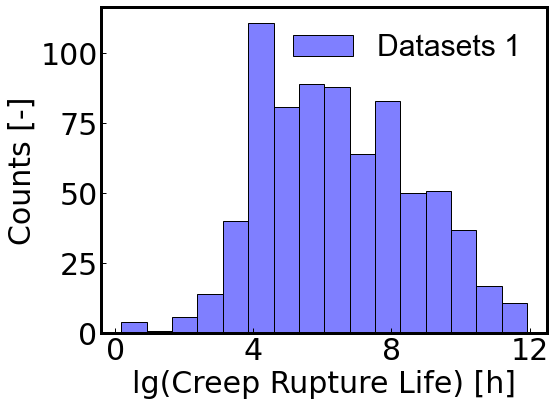

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



fontsize = 30

plt.figure(figsize=(8, 6))

# 使用Seaborn的histplot绘制直方图
sns.histplot(x1, alpha=0.5, color='blue', label='Datasets 1')

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(axis))


plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.7)

plt.xlabel(label_x, fontsize=fontsize)
plt.ylabel(label_y, fontsize=fontsize)
# plt.title('Distribution of Ni and Ti Data')
legend = plt.legend(loc='best', fontsize=fontsize,frameon=False)
plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3

plt.show()

# 模型预测图

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr

import pandas as pd
import numpy as np
import os


folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
file_path = os.path.join(folder_path, 'S1_scaled.xlsx')
df = pd.read_excel(file_path)

X_all = df.iloc[:, :-1].values  
Y_all = df.iloc[:, -1].values   

X = X_all
Y = Y_all.reshape(-1, 1)

In [37]:
import emukit
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
model_var = 0.5
ker.lengthscale.constrain_bounded(0.001, 1) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 1e2) #方差

model_gpy = GPRegression(X,Y, ker)
model_gpy.Gaussian_noise.variance = model_var**2
model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)

base_model = GPyModelWrapper(model_gpy)
f_obj =  base_model.model.predict
y_pred, y_uncer = f_obj(X)
y_uncer = np.sqrt(y_uncer[:,-1])

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


In [38]:
def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_uncer):
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    fs = 30

    min_value = 0
#     max_value = np.max(y_train)* 1.1
    max_value = 12
    gap = 4
#     lims1 = (min_value, max_value)
    lims = (min_value, max_value)
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=2)
    ax.set_xlim(lims)  # 设置横轴坐标范围
    ax.set_ylim(lims)  # 设置纵轴坐标范围
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(gap))
    ax.yaxis.set_major_locator(plt.MultipleLocator(gap))
#     ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
#     ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    
    
    ax.scatter(y_train, y_train_hat, alpha=0.5, c='navy', edgecolor='navy', s=100,label='Training data')
    ax.errorbar(y_train, y_train_hat, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)

    rmse_value = np.sqrt(mean_squared_error(y_train, y_train_hat))
#     mae_value = mean_absolute_error(y_train, y_train_hat)
    spearman_value = spearmanr(y_train, y_train_hat)[0]
    rsquared_value = r2_score(y_train, y_train_hat)


    textstr = '\n'.join((
        f'RMSE: {rmse_value:.3f}%',
        f'Spearman: {spearman_value:.3f}',
        f'R²: {rsquared_value:.3f}'
    ))

    # 在适当位置添加文本框
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=1.0)

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    
    ax.set_xlabel(f'Ground Truth ', fontproperties='Arial', fontsize=fs)
    ax.set_ylabel(f'Prediction ', fontproperties='Arial', fontsize=fs)

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # 设置边框线的粗细
    for spine in ax.spines.values():
        spine.set_linewidth(3)  # 将边框线宽度设置为2个像素
    
    ax.tick_params(direction='in', length=5, width=1, labelsize=fs, grid_alpha=0.5)
#     ax.grid(True, linestyle='-.')
    plt.subplots_adjust(wspace=0.4)

    plt.show()

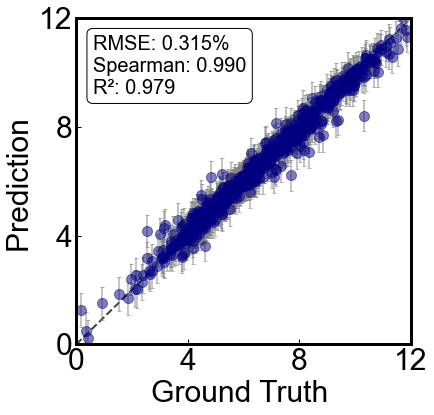

In [39]:
# 导入模型

# import pickle
# import os

# # 定义文件夹路径和模型文件名   
# folder_path = r'C:\Users\13282\Desktop\papercode\trasfer\base_model\Aryl\pca' 
# source_name = 'aryl-2'  # 替换为你的模型名称
# model_file = os.path.join(folder_path, f'{source_name}.pkl')

# # 打开文件并加载模型
# with open(model_file, 'rb') as model_file:
#     base_model = pickle.load(model_file)
        
# f_obj =  base_model.model.predict
# y_pred, y_uncer = f_obj(X)
# # y_pred = y_pred[:,-1]

prediction_vs_ground_truth_fig(Y[:, 0], y_pred[:, 0], y_uncer)

# 权重折线图

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

drop_num = 0
init_sample = 1
iter_num = 30

# folder_path_2 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Aryl\aryl1'  
# datasets_2 = ['aryl-2','aryl-4','aryl-7', ]
# label_sets =  [ 'Aryl 2', 'Aryl 4','Aryl 7',] # 'RDM+EI', 'LHS+EI','SE+EI', 'SE+traEI_a', 

# folder_path_2 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Aryl\aryl9'  
# datasets_2 = ['aryl-2','aryl-8','aryl-14', ]
# label_sets =  [ 'Aryl 2', 'Aryl 8','Aryl 14',] # 'RDM+EI', 'LHS+EI','SE+EI', 'SE+traEI_a', 

# folder_path_1 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\original\s1\nlcb'  
# datasets_1 = ['s2', ]

folder_path_2 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\original\s2\nlcb'  
datasets_2 = ['s1', ]
label_sets =  [ 'Source','Target',] # 'RDM+EI', 'LHS+EI','SE+EI', 'SE+traEI_a', 
# label_sets =  [ 's2','s1',] # 'RDM+EI', 'LHS+EI','SE+EI', 'SE+traEI_a', 

# label_sets =  datasets_1 + datasets_2

# label_sets =   datasets_2


eval_types = ['wt'] #  regret  Spearman  Edis  miny

def process_datasets(datasets, folder_path, eval_type, mean_datasets, std_datasets):
    for eval_type in eval_types:
        for dataset in datasets:
            # 从 Excel 文件中读取数据
            file_path = os.path.join(folder_path, f'{dataset}_{eval_type}.xlsx')
            df = pd.read_excel(file_path, header=0, usecols=range(iter_num))
            
            df = 1 - df

        # 找到最后一列的列名,删除最大最小行
            last_column = df.columns[-1]
            max_indices = df[last_column].nlargest(drop_num).index
            min_indices = df[last_column].nsmallest(drop_num).index
            df = df.drop(max_indices)
            df.reset_index(drop=True, inplace=True)
            df = df.drop(min_indices)
            df.reset_index(drop=True, inplace=True)

            # 计算均值并存储到列表中
            mean_data = df.mean()
            mean_datasets.append(mean_data)

            # 计算标准差并存储到列表中
            std_data = df.std()
            std_datasets.append(std_data)
            
            df = 1 - df

            # 计算均值并存储到列表中
            mean_data = df.mean()
            mean_datasets.append(mean_data)

            # 计算标准差并存储到列表中
            std_data = df.std()
            std_datasets.append(std_data)

# 初始化列表
mean_datasets = []
std_datasets = []

# 处理 datasets
# process_datasets(datasets_1, folder_path_1, eval_types, mean_datasets, std_datasets)
process_datasets(datasets_2, folder_path_2, eval_types, mean_datasets, std_datasets)


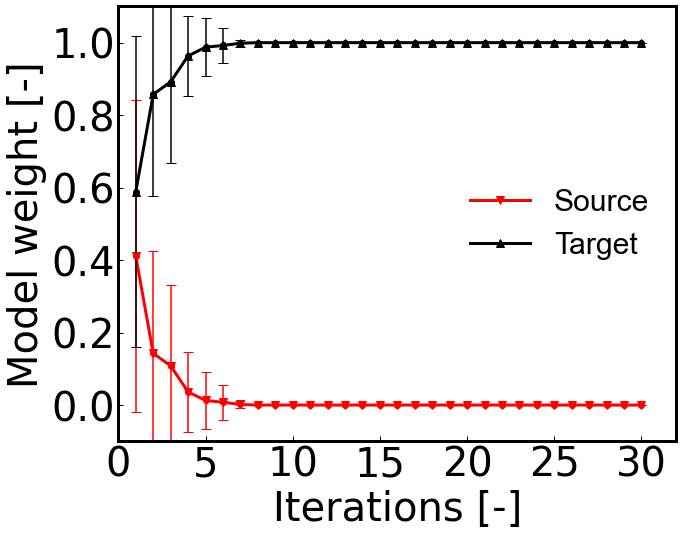

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 创建单个图形
plt.figure(figsize=(10, 8))

fontsize = 40

# color_sets =  [(147/255, 85/255, 150/255) ,'green',   'red',]
color_sets =  [ 'red','black']
# color_sets =  [  'orange','green',   'red',]
color_1 = (147/255, 85/255, 150/255)
color_2 = (116/255,160/255, 161/255)
# color_sets.append( color_1 )
# color_sets.append( color_2 )

# 循环导入每个数据集
for i, label in enumerate(label_sets):
    mean_data = mean_datasets[i]
    std_data = std_datasets[i]
    
    x_values = np.arange(0, len(mean_datasets[i])) + init_sample
    
    marker_styles = [ 'v', '^', 'D', 'P', 'x']
    line_styles = ['-', '-', '-', '-', '-', '-', '-']
        
    line, = plt.plot( x_values, mean_datasets[i], label=label, marker=marker_styles[i], markersize=8,
                     linestyle=line_styles[i] ,linewidth= 3 ,color=color_sets[i])  # i  ( 4 - i )

    # 设置每隔五个点标记一次，并标记最后一个点
    markers_num = list(range(0, len(mean_datasets[i]), 1)) 
    plt.errorbar(x_values[markers_num], mean_datasets[i][markers_num], yerr=std_datasets[i][markers_num], 
                 fmt='o', capsize=5,color=line.get_color())
        

#     plt.plot(x_values, mean_data.values, label=label, 
#              marker=marker_styles[idx % len(marker_styles)], 
#              markeredgewidth=2, markerfacecolor='white',  # 这里设置了空心圆圈
#              linestyle=line_styles[idx % len(line_styles)],
#              markevery=2,color=color_sets[i])  # 每隔两个数据点进行标记
    
#     plt.fill_between(x_values, mean_data.values - std_data.values, mean_data.values + std_data.values, alpha=0.3,
#                      color=color_sets[i])


# plt.xlim(left=0, right=30)

plt.xlim(0, iter_num + init_sample + 1 )
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))

plt.ylim(-0.1, 1.1) # (-1, 4)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))

# plt.xlabel('Number Of Samples [-]', fontsize=fontsize)
plt.xlabel('Iterations [-]', fontsize=fontsize)
# plt.ylabel('Source weight [-]', fontsize=fontsize)
plt.ylabel('Model weight [-]', fontsize=fontsize)


plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.7)

legend = plt.legend(loc='best', fontsize=30,frameon=False)
plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3

# 显示图形
plt.show()


# 数据划分

In [3]:
import pandas as pd
import os
# 读取Excel文件
folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_data'  # # Fe Co Ni Ti  Co_plus  others
file_path = os.path.join(folder_path, 'data.s1.xlsx')
df = pd.read_excel(file_path, index_col=0, header=0)

# 提取第10列到倒数第四列的数据
composition_data = df.iloc[:, 9:-3]

y_data = df.iloc[:, -1]

# 打印成分数据的列标签
column_labels = composition_data.columns

fe_data = composition_data.iloc[:72, :]

oth_data = composition_data.iloc[72:173, :]
co_data = composition_data.iloc[173:211, :]
co_plus_data = composition_data.iloc[72:211, :]

ni_data = composition_data.iloc[211:753, :]

In [4]:

folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_data' 

file_path = os.path.join(folder_path, 'data.s2.xlsx')


df_t = pd.read_excel(file_path, index_col=0, header=0)

# 分析成分数据
composition_data = df_t.iloc[:, 9:-3]


# 打印成分数据的列标签
column_labels = composition_data.columns

ti_data = composition_data.iloc[:, :]


In [50]:
target_data = ti_data  # fe_data co_data ni_data ti_data oth_data

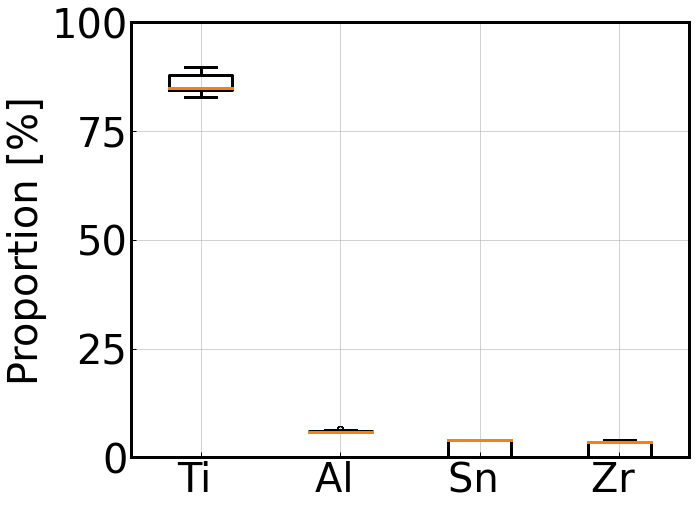

In [51]:
import matplotlib.pyplot as plt

# 选择占比最大的三列的数据
top_three_columns = target_data.mean().nlargest(4).index
top_three_data = target_data[top_three_columns]

# 创建一个图形
plt.figure(figsize=(10, 8))

fontsize = 40

# 绘制箱线图
plt.boxplot(top_three_data.values, 
            boxprops=dict(linewidth=3), 
            whiskerprops=dict(linewidth=3), 
            capprops=dict(linewidth=3), 
            medianprops=dict(linewidth=3))

# 设置横坐标为列标签
plt.xticks(range(1, len(top_three_data.columns) + 1), 
           [label.replace('(mass%)', '') for label in top_three_data.columns])

# 计算并标注均值之和
# sum_of_means = top_three_data.mean().sum()
# plt.text(0.9 * len(top_three_data.columns), 
#          plt.ylim()[1] * 0.9, 
#          f'Sum: {sum_of_means:.2f}', 
#          ha='right', va='top', color='red', fontsize=15)


plt.ylim(0, 100)  # 替换为你需要的值
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(25))

label_y = 'Proportion [%]'
plt.ylabel(label_y, fontsize=fontsize)

# 设置字体大小
plt.tick_params(axis='both', labelsize=15)
# plt.title('Ti')  # 可以设置标题
plt.grid(True)

plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.7)

# legend = plt.legend(loc='best', fontsize=30,frameon=False)
# plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3
    
# 显示图形
plt.show()


In [12]:
import numpy as np

y_log_data = np.log(y_data)

y_fe = y_log_data.iloc[:72]
y_co = y_log_data.iloc[173:211]
y_ni = y_log_data.iloc[211:753]
y_oth = y_log_data.iloc[72:173]

y_ti = df_t.iloc[:, -1]
y_ti = y_ti.iloc[:]
y_ti = np.log(y_ti)

y_combined = pd.concat([y_fe, y_co, y_ni, y_oth, y_ti], ignore_index=True)

In [55]:
y_co.shape

(38,)

In [57]:
y_oth.shape

(101,)

In [52]:
y1 = y_ti

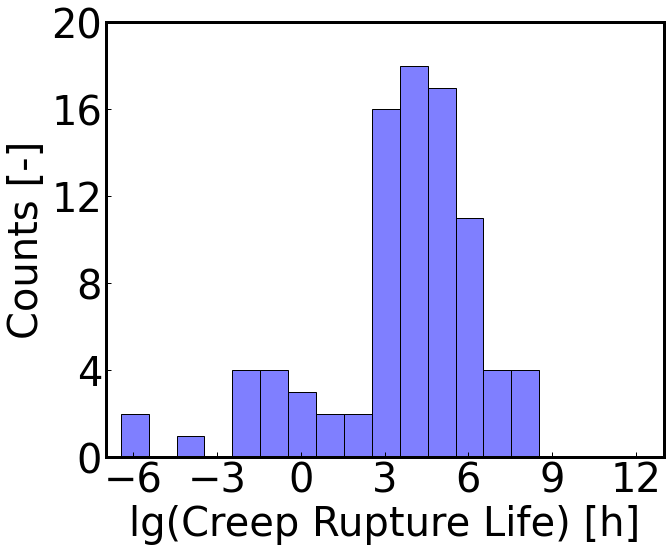

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



fontsize = 40

plt.figure(figsize=(10, 8))

binwidth = 2
axis = binwidth*2

# 使用Seaborn的histplot绘制直方图
sns.histplot(y1, alpha=0.5, color='blue', binwidth=1,) #label='Datasets 1'

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(axis))

plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.7)



plt.xlim(-7, 13)  # 替换为你需要的x轴范围
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))

# plt.ylim(0, 15)  # fe
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(3))

# plt.ylim(0, 10)  # co
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))

# plt.ylim(0, 120)  # ni
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(30))

# plt.ylim(0, 24)  # oth
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(4))

plt.ylim(0, 20)  # ti
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(4))

label_x = 'lg(Creep Rupture Life) [h]'
plt.xlabel(label_x, fontsize=fontsize)
label_y = 'Counts [-]'
plt.ylabel(label_y, fontsize=fontsize)

# legend = plt.legend(loc='best', fontsize=30,frameon=False)
# plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3
    
plt.show()

# 迁移优化

In [1]:
drop_num = 0
iter_num = 55
expe_num = 40
init_sample = 5
bs = 1

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



folder_path_1 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\matminer\ti\1111' 
datasets_1 = [   'RDM5_EI60' ,   ]  # 'standard_bo' , 'RDM5_EI60' , 
folder_path_2 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\matminer\ti\1111' 
datasets_2 = ['Fe','Co','Ni','others',]   # 'Co_plus', 'Fe','Co','Ni','others',
label_sets =  [ 'Standard BO','Transfer BO (Fe)','Transfer BO (Co)','Transfer BO (Ni)','Transfer BO (Mix)',]


eval_types = ['miny'] #  regret  Spearman  Edis  miny

def process_datasets(datasets, folder_path, eval_type, mean_datasets, std_datasets, last_columns_data):
    for eval_type in eval_types:
        for dataset in datasets:
            # 从 Excel 文件中读取数据
            file_path = os.path.join(folder_path, f'{dataset}_{eval_type}.xlsx')
            df = pd.read_excel(file_path, header=0, usecols=range(iter_num), nrows=expe_num)
            
            print(df.shape)
            
            df = -df  #转化为原始尺度
            
        # 找到最后一列的列名,删除最大最小行
            last_column = df.columns[-1]
            max_indices = df[last_column].nlargest(drop_num).index
            min_indices = df[last_column].nsmallest(drop_num).index
            df = df.drop(max_indices)
            df.reset_index(drop=True, inplace=True)
            df = df.drop(min_indices)
            df.reset_index(drop=True, inplace=True)

            # 计算均值并存储到列表中
            mean_data = df.mean()
            mean_datasets.append(mean_data)

            # 计算标准差并存储到列表中
            std_data = df.std()
            std_datasets.append(std_data)

            last_columns_data.append(df[last_column])
            
# 初始化列表
mean_datasets = []
std_datasets = []

last_columns_data = []
# 处理 datasets
# process_datasets(datasets_1, folder_path_1, eval_types, mean_datasets, std_datasets)
# process_datasets(datasets_2, folder_path_2, eval_types, mean_datasets, std_datasets)

process_datasets(datasets_1, folder_path_1,eval_types, mean_datasets, std_datasets, last_columns_data)
process_datasets(datasets_2, folder_path_2,eval_types, mean_datasets, std_datasets, last_columns_data)

(40, 55)
(40, 55)
(40, 55)
(40, 55)
(40, 55)


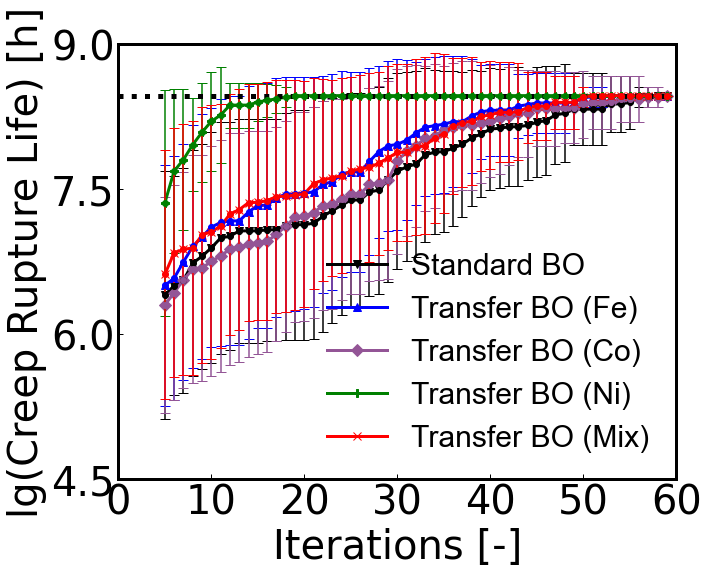

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 创建单个图形
fig = plt.figure(figsize=(10, 8))

fontsize = 40

# color_sets =  [  'blue', (147/255, 85/255, 150/255) ,'green',   'red',]
# color_sets =  [  'blue','green',   'red',]
color_sets =  [ 'black','blue', (147/255, 85/255, 150/255) ,'green',  'red',]

# color_sets =  [  'blue', 'green', ]
# color_1 = (147/255, 85/255, 150/255)
# color_2 = (116/255,160/255, 161/255)
# color_sets.append( color_1 )
# color_sets.append( color_2 )

# 循环导入每个数据集
for i, label in enumerate(label_sets):
    mean_data = mean_datasets[i]
    std_data = std_datasets[i]
    
    x_values = np.arange(0, len(mean_datasets[i])) * bs + init_sample
    
        # 设置每隔五个点标记一次，并标记最后一个点
    markers_num = list(range(0, len(mean_datasets[i]), 1)) 
    
    marker_styles = [ 'v', '^', 'D', 'P', 'x', ]
    line_styles = ['-', '-', '-', '-', '-', '-',]
        
    line, = plt.plot( x_values[markers_num], mean_datasets[i][markers_num], label=label, marker=marker_styles[i], markersize=8,
                     linestyle=line_styles[i] ,linewidth= 3 ,color=color_sets[i])  # i  ( 4 - i )


    plt.errorbar(x_values[markers_num], mean_datasets[i][markers_num], yerr=std_datasets[i][markers_num], 
                 fmt='o', capsize=5,color=line.get_color())
        

#     plt.plot(x_values, mean_data.values, label=label, 
#              marker=marker_styles[idx % len(marker_styles)], 
#              markeredgewidth=2, markerfacecolor='white',  # 这里设置了空心圆圈
#              linestyle=line_styles[idx % len(line_styles)],
#              markevery=2,color=color_sets[i])  # 每隔两个数据点进行标记
    
#     plt.fill_between(x_values, mean_data.values - std_data.values, mean_data.values + std_data.values, alpha=0.3,
#                      color=color_sets[i])

last_columns_data  = np.array(last_columns_data)
best_value = np.max(last_columns_data)
# print(best_value)
plt.axhline(best_value, color='black', linestyle=':', linewidth=5)

# y_min = np.nanmax(mean_datasets)
# plt.axhline(y_min, color='black', linestyle=':', linewidth=5)

# plt.xlim(left=0, right=30)

plt.xlim(0, iter_num* bs + init_sample )
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))

# plt.ylim(10.0, 12.0) # (-1, 4)
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.ylim(4.5, 9) # (-1, 4)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1.5))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)


# plt.xlabel('Number Of Samples [-]', fontsize=fontsize)
plt.xlabel('Iterations [-]', fontsize=fontsize)
plt.ylabel('lg(Creep Rupture Life) [h]', fontsize=fontsize)

plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.5)

legend = plt.legend(loc='best', fontsize=30,frameon=False)
plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3

# 显示图形
plt.show()

    

# 权重折线

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# # # 二维函数优化

folder_path_2 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\matminer\ti\1111'  
datasets_2 = ['Fe','Co','Ni','others',] 
label_sets =  [ 'Source (Fe)','Source (Co)','Source (Ni)','Source (Mix)',]
# label_sets =  datasets_1 + datasets_2
# label_sets =   datasets_2


eval_types = ['wt'] #  regret  Spearman  Edis  miny

def process_datasets(datasets, folder_path, eval_type, mean_datasets, std_datasets):
    for eval_type in eval_types:
        for dataset in datasets:
            # 从 Excel 文件中读取数据
            file_path = os.path.join(folder_path, f'{dataset}_{eval_type}.xlsx')
            df = pd.read_excel(file_path, header=0, usecols=range(iter_num))
            
            df = 1 - df

        # 找到最后一列的列名,删除最大最小行
            last_column = df.columns[-1]
            max_indices = df[last_column].nlargest(drop_num).index
            min_indices = df[last_column].nsmallest(drop_num).index
            df = df.drop(max_indices)
            df.reset_index(drop=True, inplace=True)
            df = df.drop(min_indices)
            df.reset_index(drop=True, inplace=True)

            # 计算均值并存储到列表中
            mean_data = df.mean()
            mean_datasets.append(mean_data)

            # 计算标准差并存储到列表中
            std_data = df.std()
            std_datasets.append(std_data)

# 初始化列表
mean_datasets = []
std_datasets = []

# 处理 datasets
# process_datasets(datasets_1, folder_path_1, eval_types, mean_datasets, std_datasets)
process_datasets(datasets_2, folder_path_2, eval_types, mean_datasets, std_datasets)


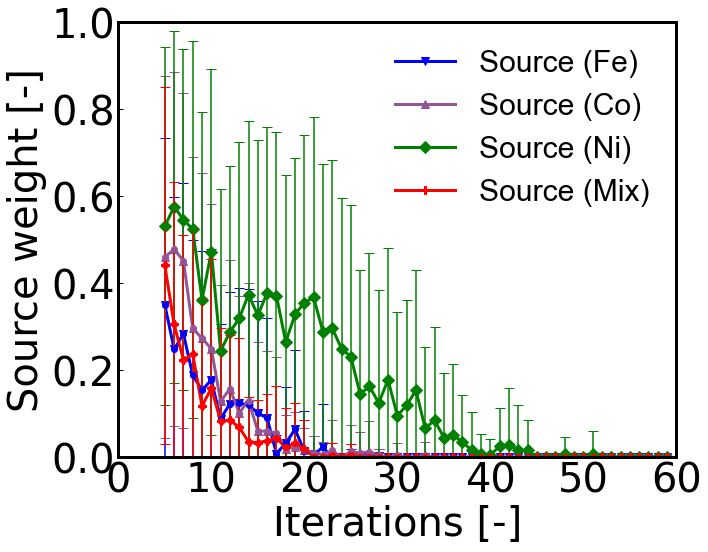

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 创建单个图形
fig = plt.figure(figsize=(10, 8))

fontsize = 40

# color_sets =  [  'blue', (147/255, 85/255, 150/255) ,'green',   'red',]
# color_sets =  [  'blue','green',   'red',]
color_sets =  [ 'blue', (147/255, 85/255, 150/255) ,'green',  'red','black',]

# color_sets =  [  'blue', 'green', ]
# color_1 = (147/255, 85/255, 150/255)
# color_2 = (116/255,160/255, 161/255)
# color_sets.append( color_1 )
# color_sets.append( color_2 )

# 循环导入每个数据集
for i, label in enumerate(label_sets):
    mean_data = mean_datasets[i]
    std_data = std_datasets[i]
    
    x_values = np.arange(0, len(mean_datasets[i])) * bs + init_sample
    
        # 设置每隔五个点标记一次，并标记最后一个点
    markers_num = list(range(0, len(mean_datasets[i]), 1)) 
    
    marker_styles = [ 'v', '^', 'D', 'P', 'x', ]
    line_styles = ['-', '-', '-', '-', '-', '-',]
        
    line, = plt.plot( x_values[markers_num], mean_datasets[i][markers_num], label=label, marker=marker_styles[i], markersize=8,
                     linestyle=line_styles[i] ,linewidth= 3 ,color=color_sets[i])  # i  ( 4 - i )


    plt.errorbar(x_values[markers_num], mean_datasets[i][markers_num], yerr=std_datasets[i][markers_num], 
                 fmt='o', capsize=5,color=line.get_color())
        

#     plt.plot(x_values, mean_data.values, label=label, 
#              marker=marker_styles[idx % len(marker_styles)], 
#              markeredgewidth=2, markerfacecolor='white',  # 这里设置了空心圆圈
#              linestyle=line_styles[idx % len(line_styles)],
#              markevery=2,color=color_sets[i])  # 每隔两个数据点进行标记
    
#     plt.fill_between(x_values, mean_data.values - std_data.values, mean_data.values + std_data.values, alpha=0.3,
#                      color=color_sets[i])

last_columns_data  = np.array(last_columns_data)
best_value = np.max(last_columns_data)
# print(best_value)
plt.axhline(best_value, color='black', linestyle=':', linewidth=5)

# y_min = np.nanmax(mean_datasets)
# plt.axhline(y_min, color='black', linestyle=':', linewidth=5)

# plt.xlim(left=0, right=30)

plt.xlim(0, iter_num* bs + init_sample )
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))

# plt.ylim(10.0, 12.0) # (-1, 4)
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.ylim(0, 1) # (-1, 4)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)


# plt.xlabel('Number Of Samples [-]', fontsize=fontsize)
plt.xlabel('Iterations [-]', fontsize=fontsize)
plt.ylabel('Source weight [-]', fontsize=fontsize)

plt.tick_params(direction='in', length=5, width=1, labelsize=fontsize, grid_alpha=0.5)

legend = plt.legend(loc='best', fontsize=30,frameon=False)
plt.setp(legend.get_texts(), fontname='Arial')
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)  # Set frame width to 3

# 显示图形
plt.show()

    

# 描述符分析

In [3]:
import pandas as pd
import os

# 设置文件夹路径和数据集名称
folder_path_1 = r'C:\Users\13282\Desktop\papercode\data\Aryl\original_data'
datasets_1 = 'Scaled_dataset'

file_path = os.path.join(folder_path_1, f"{datasets_1}.csv")
data = pd.read_csv(file_path)

columns = data.columns.tolist()


In [4]:
# 定义四类列标签
aryl_halide_cols = [col for col in columns if col.startswith('aryl_halide_')]
additive_cols = [col for col in columns if col.startswith('additive_')]
base_cols = [col for col in columns if col.startswith('base_')]
ligand_cols = [col for col in columns if col.startswith('ligand_')]

In [22]:
# 删除特定前缀和点
def clean_column_name(col, prefix):
    if col.startswith(prefix):
        # 删除前缀
        col = col[len(prefix):]
    col = col.lstrip('.').rstrip('.')
    col = col.replace('_', '-')
    return col

# 清理列标签
aryl_halide_cols = [clean_column_name(col, 'aryl_halide_') for col in aryl_halide_cols]
additive_cols = [clean_column_name(col, 'additive_') for col in additive_cols]
base_cols = [clean_column_name(col, 'base_') for col in base_cols]
ligand_cols = [clean_column_name(col, 'ligand_') for col in ligand_cols]